In [1]:
import pandas as pd
import os
from datetime import datetime
from datetime import datetime, timedelta
import time as time_lib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import pickle

import matplotlib.cbook as cbook
# import random
from os.path import dirname, join as pjoin
import scipy.io as sio
import statsmodels.api as sm

In [17]:
def evalprobcast(y,yhats):
    yo = y[:,np.newaxis,np.newaxis]
    TMP = (yo >= yhats[:,0,:,:])&(yo <= yhats[:,1,:,:])
    PICP = np.mean(TMP,0)
    width = yhats[:,1,:,:] - yhats[:,0,:,:]
    avgwidth = np.mean(width,0)
    maxwidth = np.max(width,0)
    return PICP, avgwidth, maxwidth
def PICP(y,upper,lower):
    PICP = sum((y > lower) & (y < upper))/y.shape[0]
    return PICP
def widthavgcal(upper,lower):
    widthavg = (upper-lower).mean()
    return widthavg
def widthmaxcal(upper,lower):
    widthmax = (upper-lower).max()
    return widthmax

In [3]:
# ax --> figure
# x,y,z ---> lists of x and y (points), z is annotate list
# num_show ---> annotate for index that mod with num_show = 0
def annotate_fig(ax,x,y,z,num_show,color=None, xytext_default=(-5, 5)):
    for i, (X, Y, Z) in enumerate(zip(x, y, z)):
        if i%num_show ==0:
            ax.annotate('{}'.format(round(Z,2)), xy=(X,Y), xytext=xytext_default, ha='right',
                        textcoords='offset points',color=color)
def report_savefig(plotname):
    fig_folder_path = "/Users/worachitjdai/Thesis/conference_code/figures/"
    fig.savefig(fig_folder_path+plotname+".pdf",format='pdf',bbox_inches='tight',pad_inches=0,transparent=True)

In [5]:
quantiles = [0.05, 0.95]
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
gammavec = list(np.round(np.arange(0.5, 1.01, 0.05),2))

In [6]:
resultfolderpath = "/Users/worachitjdai/Thesis/conference_code/results"
datasimfolderpath = "/Users/worachitjdai/Thesis/conference_code/data/simulated_data"
datasolarfolderpath = "/Users/worachitjdai/Thesis/conference_code/data/solar_experiment"

# Simulated data result

## One realization plot

### PI plot

In [10]:
# Import result
X = np.load(os.path.join(datasimfolderpath,'x_train.npy'))
x = X[:,1].reshape(X.shape[0],1)
Xtest = np.load(os.path.join(datasimfolderpath,'x_test.npy'))
xtest = Xtest[:,1].reshape(Xtest.shape[0],1)
y = np.load(os.path.join(datasimfolderpath,'y_train.npy'))
ytest = np.load(os.path.join(datasimfolderpath,'y_test.npy'))

yhats_train_q = np.load(os.path.join(resultfolderpath,'yhats_train_qrqrf.npy'))
yhats_test_q = np.load(os.path.join(resultfolderpath,'yhats_test_qrqrf.npy'))
yhats_train = np.load(os.path.join(resultfolderpath,'yhats_train_formulation.npy'))
yhats_test = np.load(os.path.join(resultfolderpath,'yhats_test_formulation.npy'))

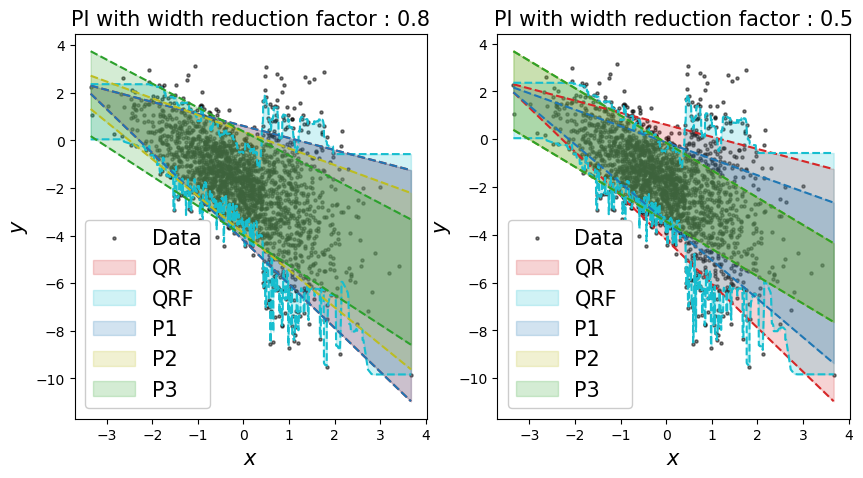

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=2)
gammavec = list(np.round(np.arange(0.5, 1.01, 0.05),2))
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
gamma_list = [0.8,0.5]
quantiles = [0.05,0.95]
fig.set_size_inches(10,5)
i = 0
color_list = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
for gamma in gamma_list:
    gamma_index = gammavec.index(gamma)
    xplot = x.flatten()
    ax[i].scatter(xplot,y,label='Data',color='black',alpha=0.5,s=5)
    for k in range(2): ## Upper-lower bound
        ax[i].plot(xplot,yhats_train_q[:,k,0,-1],color=color_list[0],linestyle='dashed') #plot for 0.9 confidence
        ax[i].plot(xplot,yhats_train_q[:,k,1,-1],color=color_list[1],linestyle='dashed') #plot for 0.9 confidence
        ax[i].plot(xplot,yhats_train[:,k,0,gamma_index],color=color_list[2],linestyle='dashed')
        ax[i].plot(xplot,yhats_train[:,k,1,gamma_index],color=color_list[3],linestyle='dashed')
        ax[i].plot(xplot,yhats_train[:,k,2,gamma_index],color=color_list[4],linestyle='dashed')
    ax[i].fill_between(xplot,yhats_train_q[:,0,0,-1],yhats_train_q[:,1,0,-1],alpha=0.2,color=color_list[0],label='QR')
    ax[i].fill_between(xplot,yhats_train_q[:,0,1,-1],yhats_train_q[:,1,1,-1],alpha=0.2,color=color_list[1],label='QRF')
    ax[i].fill_between(xplot,yhats_train[:,0,0,gamma_index],yhats_train[:,1,0,gamma_index],alpha=0.2,color=color_list[2],label='P1')
    ax[i].fill_between(xplot,yhats_train[:,0,1,gamma_index],yhats_train[:,1,1,gamma_index],alpha=0.2,color=color_list[3],label='P2')
    ax[i].fill_between(xplot,yhats_train[:,0,2,gamma_index],yhats_train[:,1,2,gamma_index],alpha=0.2,color=color_list[4],label='P3')
    ax[i].set_title('PI with width reduction factor : '+str(gamma),fontsize=15)
    ax[i].legend(fontsize=15,framealpha=1)
    ax[i].set_xlabel("$x$",fontsize=15)
    ax[i].set_ylabel("$y$",fontsize=15)
    i = i+1
# report_savefig('toy_comparing_pis')

### Histogram

In [13]:
# Calculate PICP
PICP_QR = []
PICP_QRF = []
PICP_P1 = []
PICP_P2 = []
PICP_P3 = []

for conf_int in conf_interval_list:
    conf_index = conf_interval_list.index(conf_int)
    PICP_QR.append(PICP(y.flatten(),yhats_train_q[:,1,0,conf_index],yhats_train_q[:,0,0,conf_index]))
    PICP_QRF.append(PICP(y.flatten(),yhats_train_q[:,1,1,conf_index],yhats_train_q[:,0,1,conf_index]))

for gamma in gammavec:
    gamma_index = gammavec.index(gamma)
    PICP_P1.append(PICP(y.flatten(),yhats_train[:,1,0,gamma_index],yhats_train[:,0,0,gamma_index]))
    PICP_P2.append(PICP(y.flatten(),yhats_train[:,1,1,gamma_index],yhats_train[:,0,1,gamma_index]))
    PICP_P3.append(PICP(y.flatten(),yhats_train[:,1,2,gamma_index],yhats_train[:,0,2,gamma_index]))

PICP of P1 given penalty_show 0.9
PICP of P2 given penalty_show 0.889
PICP of P3 given penalty_show 0.877
closest PICP of QR given penalty_show 0.9
PICP of P1 given penalty_show 0.884
PICP of P2 given penalty_show 0.8405
PICP of P3 given penalty_show 0.8695
closest PICP of QR given penalty_show 0.9


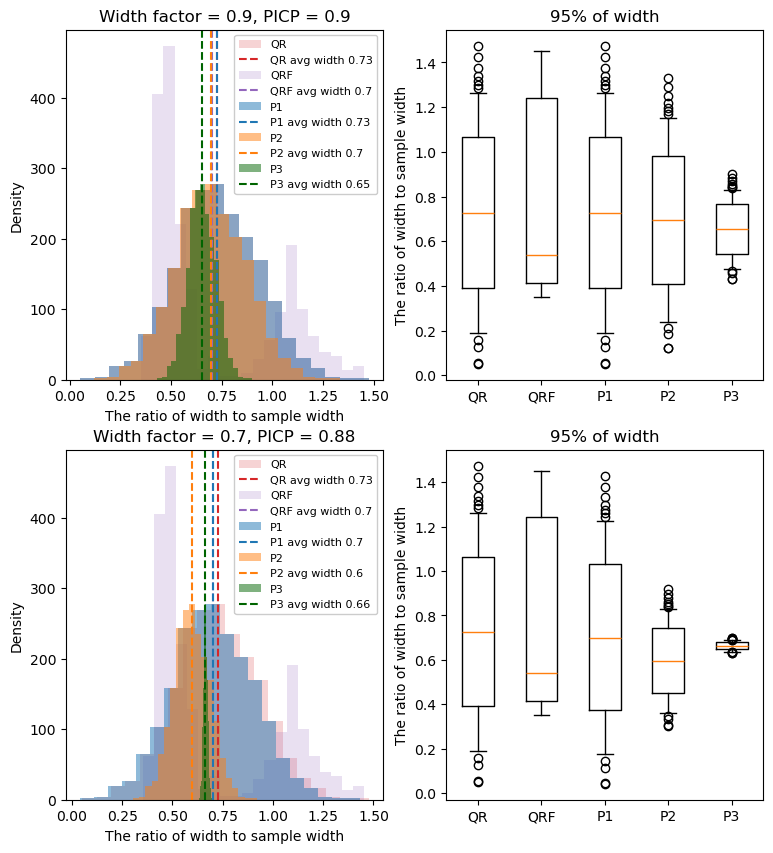

In [14]:
gamma_list = [0.9,0.75]
gamma_list = [0.9,0.7]
fig,ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(9, 10)
i = 0
sample_width = abs(np.quantile(y,quantiles[1])-np.quantile(y,quantiles[0]))
color_list = ['tab:red','tab:purple','tab:blue','tab:orange','darkgreen']
label_hist_plot = ['QR', 'QRF', 'P1', 'P2', 'P3']
alpha_plot = [0.2, 0.2, 0.5, 0.5, 0.5]

for gamma in gamma_list:
    #FIND CONFIDENCE INTERVAL CLOSEST TO PICP FROM P1 GIVEN PENALTY_SHOW
    gamma_index = gammavec.index(gamma)
    PICP_P1_given_penalty = PICP_P1[gamma_index]
    PICP_P2_given_penalty = PICP_P2[gamma_index]
    PICP_P3_given_penalty = PICP_P3[gamma_index]
    
    print('PICP of P1 given penalty_show '+str(PICP_P1_given_penalty))
    print('PICP of P2 given penalty_show '+str(PICP_P2_given_penalty))
    print('PICP of P3 given penalty_show '+str(PICP_P3_given_penalty))
    
    sorted_list = sorted(PICP_QR, key=lambda x: abs(PICP_P1_given_penalty - x))
    sorted_list_2 = sorted(conf_interval_list, key=lambda x: abs(sorted_list[0] - x))
    #Find the closest PICP of QR to P1 with given gamma
    conf_show = sorted_list_2[0] 
    print('closest PICP of QR given penalty_show '+str(conf_show))
    conf_index = conf_interval_list.index(conf_show)
      
    width_QR = (yhats_train_q[:,1,0,conf_index]-yhats_train_q[:,0,0,conf_index])/sample_width
    width_QRF = (yhats_train_q[:,1,1,conf_index]-yhats_train_q[:,0,1,conf_index])/sample_width
    width_P1 = (yhats_train[:,1,0,gamma_index]-yhats_train[:,0,0,gamma_index])/sample_width
    width_P2 = (yhats_train[:,1,1,gamma_index]-yhats_train[:,0,1,gamma_index])/sample_width
    width_P3 = (yhats_train[:,1,2,gamma_index]-yhats_train[:,0,2,gamma_index])/sample_width
    width_plot = [width_QR, width_QRF, width_P1, width_P2, width_P3]

    stats = {}
    for j in range(len(width_plot)):
        ax[i,0].hist(width_plot[j],bins=20,alpha = alpha_plot[j], density=False,color = color_list[j],label=label_hist_plot[j])
        ax[i,0].axvline(np.mean(width_plot[j]),color = color_list[j], linestyle='dashed', linewidth=1.5, label = label_hist_plot[j]+' avg width '+str(round(np.mean(width_plot[j]),2)))
        # Compute the boxplot stats (as in the default matplotlib implementation)
        stats[label_hist_plot[j]] = cbook.boxplot_stats(width_plot[j])[0]
        # For all boxes compute the 5th and 95th percentiles
        stats[label_hist_plot[j]]['q1'], stats[label_hist_plot[j]]['q3'] = np.percentile(width_plot[j], [5, 95])
    
    ax[i,0].set_title("Width factor = "+str(gamma)+", PICP = "+str(round(PICP_P1_given_penalty,2)))
    ax[i,0].legend(fontsize=8,framealpha=1)
    ax[i,0].set_xlabel("The ratio of width to sample width")
    ax[i,0].set_ylabel("Density")
    
    bp = ax[i,1].bxp([stats['QR'], stats['QRF'], stats['P1'], stats['P2'], stats['P3']],meanline = True)
    ax[i,1].set_xticklabels(label_hist_plot)
    ax[i,1].set_ylabel('The ratio of width to sample width')
    ax[i,1].set_title('95% of width')
    i = i +1
# report_savefig("toy_histogram_width_qrqrfp1p2p3")


## 100 trials plot

In [18]:
data_100_ally = np.load(os.path.join(datasimfolderpath,'data_100_y.npy'))
data_100_x = np.load(os.path.join(datasimfolderpath,'data_100_x.npy'))
# avgforplot = sio.loadmat(os.path.join(datasimfolderpath,'avgpicpwidth-dividesamplewidth')) #Width are divided by sample width
allyhats = np.load(os.path.join(resultfolderpath,'allyhats.npy'))
yhatsqr = np.load(os.path.join(resultfolderpath,'yhatsqr.npy'))
yhatsqrf = np.load(os.path.join(resultfolderpath,'yhatsqrf.npy'))

In [19]:
allpicp_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES
allavgwidth_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES
allmaxwidth_Q = np.zeros((2,len(conf_interval_list),data_100_ally.shape[1])) # 2(QR,QRF) x NUM_CONF x SAMPLES

## Calculating PICP, width for QR, QRF (width are divided with sample_width)
quantiles = [0.05,0.95]
qr_method_forecasts = [yhatsqr,yhatsqrf]
for i in range(data_100_ally.shape[1]): #Iterate over SAMPLES
    sample_width = np.quantile(data_100_ally[:,i],quantiles[1])-np.quantile(data_100_ally[:,i],quantiles[0])
    j = 0
    for conf_int in conf_interval_list: #Iterate over conf_interval
        k = 0
        for yhat in qr_method_forecasts:
            lower = yhat[:,0,j,i]
            upper = yhat[:,1,j,i]
            allpicp_Q[k,j,i] = PICP(data_100_ally[:,i],upper,lower)
            allavgwidth_Q[k,j,i] = widthavgcal(upper,lower)/sample_width
            allmaxwidth_Q[k,j,i] = widthmaxcal(upper,lower)/sample_width
            k = k+1
        j = j + 1

# Averaging all samples

## QR
width_dict_QR_avgallsamples = {"avg":[],"max":[]}
width_dict_QR_avgallsamples["avg"] = np.mean(allavgwidth_Q,axis=2)[0]
width_dict_QR_avgallsamples["max"] = np.mean(allmaxwidth_Q,axis=2)[0]
PICP_QR_avg = np.mean(allpicp_Q,axis=2)[0]
## QRF 
width_dict_QRF_avgallsamples = {"avg":[],"max":[]}
width_dict_QRF_avgallsamples["avg"] = np.mean(allavgwidth_Q,axis=2)[1]
width_dict_QRF_avgallsamples["max"] = np.mean(allmaxwidth_Q,axis=2)[1]
PICP_QRF_avg =np.mean(allpicp_Q,axis=2)[1]
# P1, P2, P3
allPICP_P = np.zeros((3,len(gammavec),data_100_ally.shape[1])) # 3(P1,P2,P3) x NUM_GAMMA x SAMPLES
allavgwidth_P = np.zeros((3,len(gammavec),data_100_ally.shape[1]))
allmaxwidth_P = np.zeros((3,len(gammavec),data_100_ally.shape[1]))
for i in range(data_100_ally.shape[1]):  
    sample_width = np.quantile(data_100_ally[:,i],quantiles[1])-np.quantile(data_100_ally[:,i],quantiles[0])
    yhats = allyhats[:,:,:,:,i]
    [PICP, avgwidth, maxwidth] = evalprobcast(data_100_ally[:,i],yhats)
    allPICP_P[:,:,i] = PICP
    allavgwidth_P[:,:,i] = avgwidth/sample_width
    allmaxwidth_P[:,:,i] = maxwidth/sample_width

avgPICP = np.mean(allPICP_P,2)
avgavgwidth = np.mean(allavgwidth_P,2)
avgmaxwidth = np.mean(allmaxwidth_P,2)

(0.4, 2.15)

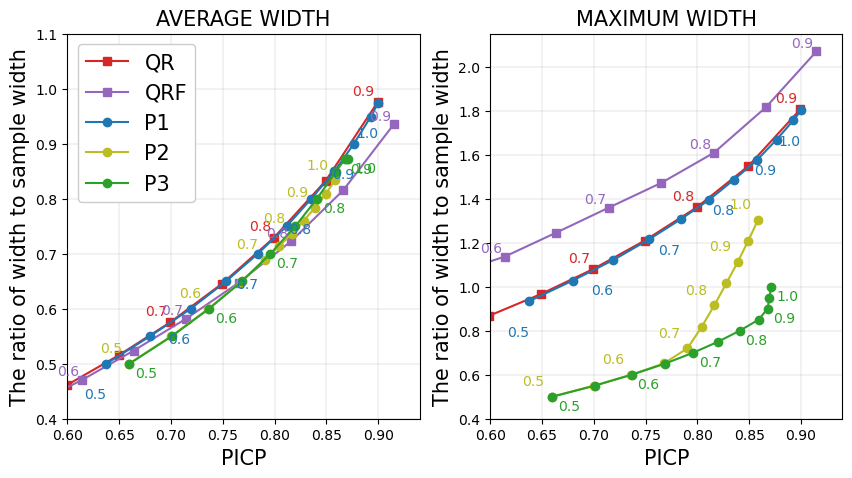

In [20]:
# For 100 realizations
## PICP and width tradeoff
nrows = 1
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(10, 5)

widthtypelist = ['avg','max']
formulation_color = ['tab:red','tab:purple','tab:blue','tab:olive','tab:green']
formulation_label = ['QR','QRF','P1','P2','P3']
row = 0
i = 0
for widthtype in widthtypelist:
    # For QR
    x_QR = PICP_QR_avg
    y_2_QR = width_dict_QR_avgallsamples[widthtype]
    z_QR = conf_interval_list
    ax[row].plot(x_QR,y_2_QR,marker='s',color=formulation_color[0],label=formulation_label[0])
    annotate_fig(ax[row],x_QR,y_2_QR,z_QR,2,color=formulation_color[0], xytext_default=(-2, 5))

    # For QRF
    x_QRF = PICP_QRF_avg
    y_2_QRF = width_dict_QRF_avgallsamples[widthtype]
    z_QRF = conf_interval_list
    ax[row].plot(x_QRF,y_2_QRF,marker='s',color=formulation_color[1],label=formulation_label[1])
    annotate_fig(ax[row],x_QRF,y_2_QRF,z_QRF,2,color=formulation_color[1], xytext_default=(-2, 3))

    #For P1, P2, P3
    formulation_textpos = [(0,-25),(-5,8),(20,-10)]
    for j in range(avgPICP.shape[0]):
        x_form = avgPICP[j]
        if widthtype == 'avg':
            y_form = avgavgwidth[j]
        else:
            y_form = avgmaxwidth[j]
        z = gammavec
        ax[row].plot(x_form,y_form,marker="o",color = formulation_color[j+2],label=formulation_label[j+2])
        annotate_fig(ax[row],x_form,y_form,z,2,color=formulation_color[j+2], xytext_default=formulation_textpos[j])

    ax[0].legend(loc='upper left',fontsize=15,framealpha=1)
    ax[row].set_xlabel("PICP",fontsize=15)
    ax[row].set_ylabel("The ratio of width to sample width",fontsize=15)
    ax[row].grid(color='k', linestyle='dashed', linewidth=0.1)
    row = row+1
    i = i+1

ax[0].set_title("AVERAGE WIDTH",fontsize=15)
ax[0].set_xlim(0.6, 0.94)
ax[0].set_ylim(0.4,1.1)

ax[1].set_title("MAXIMUM WIDTH",fontsize=15)
ax[1].set_xlim(0.6, 0.94)
ax[1].set_ylim(0.4,2.15)
# report_savefig("toy_avg_picp_vs_width")


## Non-linear function PI plot

### High variance data

In [14]:
# Import high variance data
dict_path = os.path.join(resultfolderpath, 'data_quad.pkl')
with open(dict_path, 'rb') as pickle_file:
    data_quad = pickle.load(pickle_file)

Text(0, 0.5, '$y$')

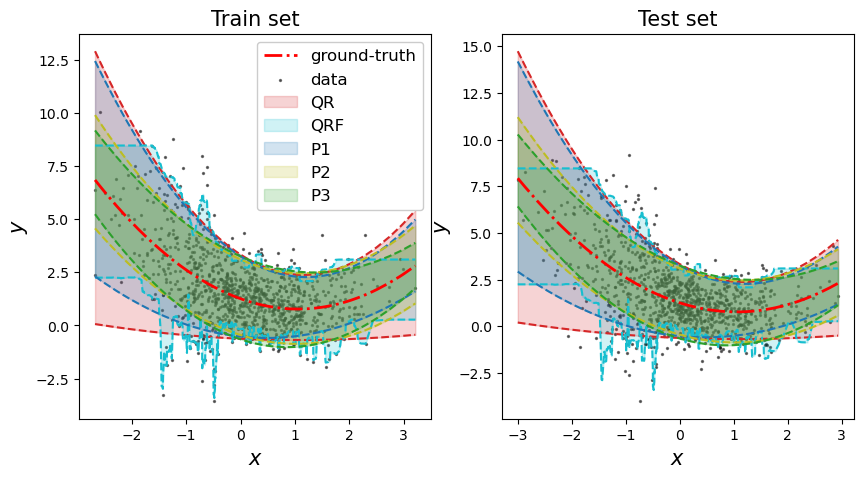

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
colorlist = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
labellist = ['QR','QRF','P1','P2','P3']
dataplot = data_quad

ax[0].plot(dataplot['x'],dataplot['y0'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[0].scatter(dataplot['x'],dataplot['y'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[0].fill_between(dataplot['x'].flatten(),dataplot['yhat'][:,0,i],dataplot['yhat'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[0].set_title('Train set',fontsize=15)
ax[0].set_xlabel('$x$',fontsize=15)
ax[0].set_ylabel('$y$',fontsize=15)
ax[0].legend(fontsize=12,framealpha=1)

ax[1].plot(dataplot['xtest'],dataplot['y0test'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[1].scatter(dataplot['xtest'],dataplot['ytest'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[1].fill_between(dataplot['xtest'].flatten(),dataplot['yhattest'][:,0,i],dataplot['yhattest'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[1].set_title('Test set',fontsize=15)
ax[1].set_xlabel('$x$',fontsize=15)
ax[1].set_ylabel('$y$',fontsize=15)
# report_savefig('quadfit-highnoise')

### Low variance data

In [16]:
# Import low variance data
dict_path = os.path.join(resultfolderpath, 'data_quad_lownoise.pkl')
with open(dict_path, 'rb') as pickle_file:
    data_quad_lownoise = pickle.load(pickle_file)

Text(0, 0.5, '$y$')

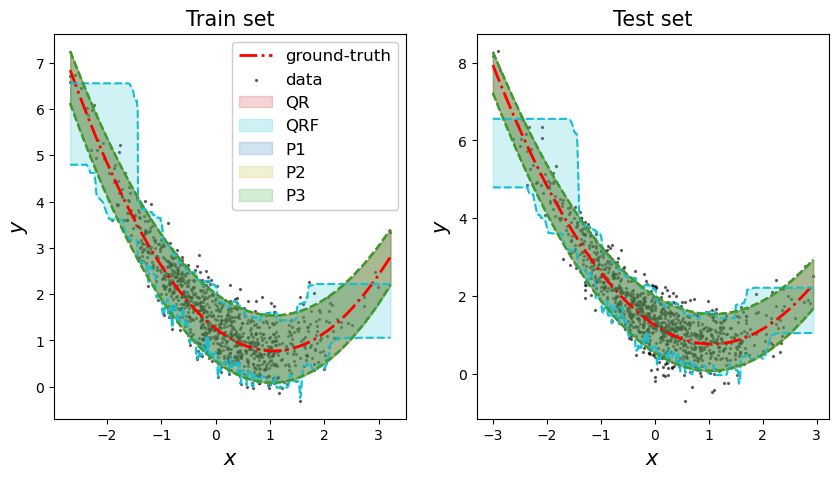

In [17]:
fig,ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(10,5)
colorlist = ['tab:red','tab:cyan','tab:blue','tab:olive','tab:green']
labellist = ['QR','QRF','P1','P2','P3']
# colorlist = ['tab:red','tab:blue','tab:olive','tab:green']
# labellist = ['QR','P1','P2','P3']
dataplot = data_quad_lownoise
# High variance
ax[0].plot(dataplot['x'],dataplot['y0'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[0].scatter(dataplot['x'],dataplot['y'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[0].plot(dataplot['x'],dataplot['yhat'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[0].fill_between(dataplot['x'].flatten(),dataplot['yhat'][:,0,i],dataplot['yhat'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[0].set_title('Train set',fontsize=15)
ax[0].set_xlabel('$x$',fontsize=15)
ax[0].set_ylabel('$y$',fontsize=15)
ax[0].legend(fontsize=12,framealpha=1)

ax[1].plot(dataplot['xtest'],dataplot['y0test'],color='red',linestyle='-.',linewidth=2,label='ground-truth')
ax[1].scatter(dataplot['xtest'],dataplot['ytest'],color='black',alpha=0.5,s=2,label='data')
for i in range(len(colorlist)):
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,0,i],color=colorlist[i],linestyle='dashed')
    ax[1].plot(dataplot['xtest'],dataplot['yhattest'][:,1,i],color=colorlist[i],linestyle='dashed')
    ax[1].fill_between(dataplot['xtest'].flatten(),dataplot['yhattest'][:,0,i],dataplot['yhattest'][:,1,i],alpha=0.2,color=colorlist[i],label=labellist[i])

ax[1].set_title('Test set',fontsize=15)
ax[1].set_xlabel('$x$',fontsize=15)
ax[1].set_ylabel('$y$',fontsize=15)
# report_savefig('quadfit-lownoise')


# Solar forecast results

## Import the result

In [18]:
quantiles = [0.05,0.95]
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))

In [19]:
## Load QR result
quantiles = [0.05,0.95]
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
qr_morning = pd.read_csv(os.path.join(resultfolderpath,'qr_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_noon = pd.read_csv(os.path.join(resultfolderpath,'qr_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
qr_evening = pd.read_csv(os.path.join(resultfolderpath,'qr_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_QR = [qr_morning,qr_noon,qr_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_qr.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_qr = pickle.load(pickle_file)
dict_path = os.path.join(resultfolderpath, 'pinball_qr.pkl')
with open(dict_path, 'rb') as pickle_file:
    pinball_loss_QR = pickle.load(pickle_file)

## Load QRF result
qrf_morning = pd.read_csv(os.path.join(resultfolderpath,'qrf_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_noon = pd.read_csv(os.path.join(resultfolderpath,'qrf_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_evening = pd.read_csv(os.path.join(resultfolderpath,'qrf_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_QRF = [qrf_morning,qrf_noon,qrf_evening]

qrf_morning_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_morning_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_noon_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_noon_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
qrf_evening_test = pd.read_csv(os.path.join(resultfolderpath,'qrf_evening_test.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_test_QRF = [qrf_morning_test, qrf_noon_test, qrf_evening_test]

## Load P1 result
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
p1_morning = pd.read_csv(os.path.join(resultfolderpath,'p1_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p1_noon = pd.read_csv(os.path.join(resultfolderpath,'p1_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p1_evening = pd.read_csv(os.path.join(resultfolderpath,'p1_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P1 = [p1_morning,p1_noon,p1_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p1.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P1 = pickle.load(pickle_file)

## Load P3 result
p3_morning = pd.read_csv(os.path.join(resultfolderpath,'p3_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_noon = pd.read_csv(os.path.join(resultfolderpath,'p3_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_evening = pd.read_csv(os.path.join(resultfolderpath,'p3_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P3 = [p3_morning,p3_noon,p3_evening]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p3.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P3 = pickle.load(pickle_file)

## Load P3 at dec = 0.5 result
p3_morning_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_morning.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_noon_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_noon.csv'), index_col='Datetime', parse_dates=['Datetime'])
p3_evening_05 = pd.read_csv(os.path.join(resultfolderpath,'p3_05_evening.csv'), index_col='Datetime', parse_dates=['Datetime'])
All_y_train_P3_05 = [p3_morning_05,p3_noon_05,p3_evening_05]

# Load the dictionary from the Pickle file
dict_path = os.path.join(resultfolderpath, 'beta_p3_05.pkl')
with open(dict_path, 'rb') as pickle_file:
    beta_model_P3_05 = pickle.load(pickle_file)

In [20]:
# Load train set
with open(os.path.join(resultfolderpath, 'width_dict_qr.pkl'), 'rb') as pickle_file:
    width_dict_QR = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_qr.pkl'), 'rb') as pickle_file:
    PICP_QR = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'qsscore_dict_qr.pkl'), 'rb') as pickle_file:
    QS_score_QR = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_qrf.pkl'), 'rb') as pickle_file:
    width_dict_QRF = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_qrf.pkl'), 'rb') as pickle_file:
    PICP_QRF = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_p1.pkl'), 'rb') as pickle_file:
    width_dict_P1 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_p1.pkl'), 'rb') as pickle_file:
    PICP_P1 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'qsscore_dict_p1.pkl'), 'rb') as pickle_file:
    QS_score_P1 = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_p3.pkl'), 'rb') as pickle_file:
    width_dict_P3 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_p3.pkl'), 'rb') as pickle_file:
    PICP_P3 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'qsscore_dict_p3.pkl'), 'rb') as pickle_file:
    QS_score_P3 = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'picp_dict_p3_05.pkl'), 'rb') as pickle_file:
    PICP_P3_05 = pickle.load(pickle_file)

## PICP and PI widths plot

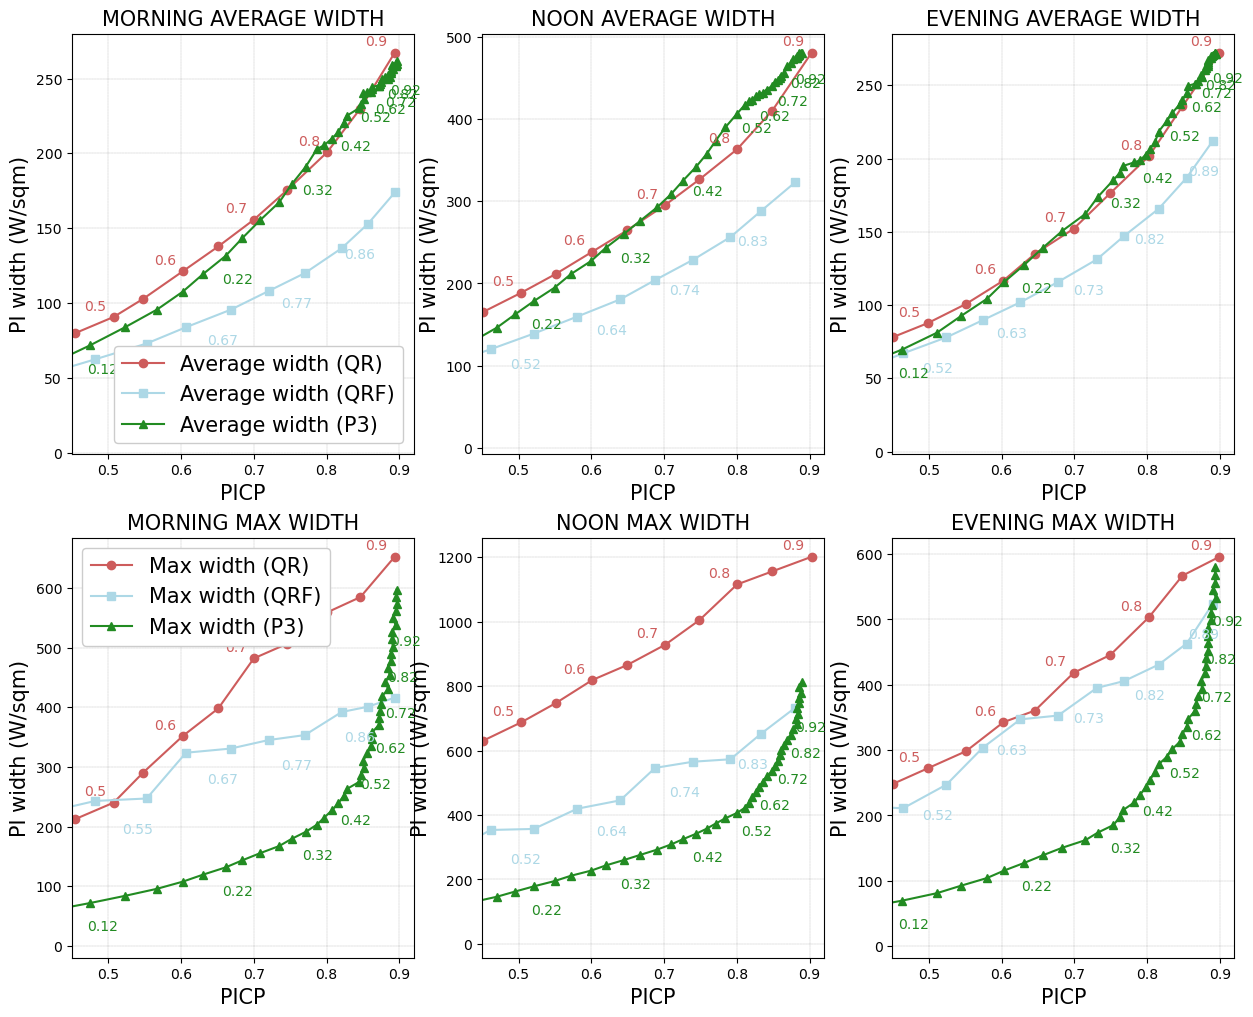

In [21]:
## PICP and width tradeoff
nrows = 2
ncols = 3
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(15, 12)
color_list = ['indianred','lightblue','forestgreen']
widthtypelist = {'norm1':'Average','max':'Max'}

for i in range(3):
    if i == 0:
        period = "morning"
        qrf_end = -3
    elif i == 1:
        period = "noon"
        qrf_end = -3
    else:
        period = "evening"
        qrf_end = -2

    j  = 0
    for widthtype in widthtypelist:
        ax[j,i].plot(PICP_QR[period],width_dict_QR[period,widthtype],c=color_list[0],marker="o",label=widthtypelist[widthtype]+' width (QR)')
        annotate_fig(ax[j,i],PICP_QR[period],width_dict_QR[period,widthtype],conf_interval_list,2,xytext_default=(-5,5),color=color_list[0])
        
        ax[j,i].plot(PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],c=color_list[1],marker="s",label=widthtypelist[widthtype]+' width (QRF)')    
        annotate_fig(ax[j,i],PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],PICP_QRF[period][0:qrf_end],2,xytext_default=(5,-25),color=color_list[1])

        ax[j,i].plot(PICP_P3[period],width_dict_P3[period,widthtype],marker="^",color=color_list[2],label=widthtypelist[widthtype]+' width (P3)')
        annotate_fig(ax[j,i],PICP_P3[period],width_dict_P3[period,widthtype],dec_factor,5,xytext_default=(20,-20),color=color_list[2])

        ax[j,i].set_title(period.upper()+" "+widthtypelist[widthtype].upper()+" WIDTH",fontsize=15)
        ax[j,i].set_xlabel("PICP",fontsize = 15)
        ax[j,i].set_ylabel("PI width (W/sqm)",fontsize = 15)
        ax[j,i].set_xlim(0.45, 0.92)
        ax[j,i].grid(color='k', linestyle='dashed', linewidth=0.1)
        
        if i==0:
            ax[j,i].legend(fontsize = 15,framealpha=1)
        
        j = j + 1


# report_savefig('compare_picp_vs_width')

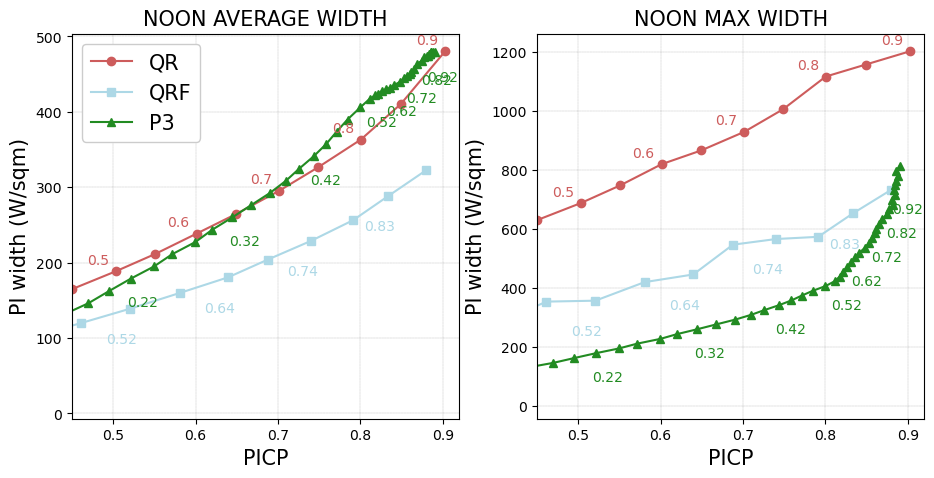

In [22]:
## PICP and width tradeoff
nrows = 1
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols)
fig.set_size_inches(11, 5)
color_list = ['indianred','lightblue','forestgreen']
widthtypelist = {'norm1':'Average','max':'Max'}

i = 1
if i == 0:
    period = "morning"
    qrf_end = -3
elif i == 1:
    period = "noon"
    qrf_end = -3
else:
    period = "evening"
    qrf_end = -2

j  = 0
for widthtype in widthtypelist:
    ax[j].plot(PICP_QR[period],width_dict_QR[period,widthtype],c=color_list[0],marker="o",label='QR')
    annotate_fig(ax[j],PICP_QR[period],width_dict_QR[period,widthtype],conf_interval_list,2,xytext_default=(-5,5),color=color_list[0])
    
    ax[j].plot(PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],c=color_list[1],marker="s",label='QRF')    
    annotate_fig(ax[j],PICP_QRF[period][0:qrf_end],width_dict_QRF[period,widthtype][0:qrf_end],PICP_QRF[period][0:qrf_end],2,xytext_default=(5,-25),color=color_list[1])

    ax[j].plot(PICP_P3[period],width_dict_P3[period,widthtype],marker="^",color=color_list[2],label='P3')
    annotate_fig(ax[j],PICP_P3[period],width_dict_P3[period,widthtype],dec_factor,5,xytext_default=(20,-20),color=color_list[2])

    ax[j].set_title(period.upper()+" "+widthtypelist[widthtype].upper()+" WIDTH",fontsize=15)
    ax[j].set_xlabel("PICP",fontsize = 15)
    ax[j].set_ylabel("PI width (W/sqm)",fontsize = 15)
    ax[j].set_xlim(0.45, 0.92)
    ax[j].grid(color='k', linestyle='dashed', linewidth=0.1)      
    j = j + 1
    
ax[0].legend(fontsize = 15,framealpha=1)
    

# report_savefig('compare_picp_vs_width_noon')

## PIs and measured irradiance

2022-08-20
2022-08-23


([<matplotlib.axis.XTick at 0x14fc9bf10>,
 [Text(1.0, 0, '08-20 08:00'),
  Text(9.0, 0, '08-20 10:00'),
  Text(17.0, 0, '08-20 12:00'),
  Text(25.0, 0, '08-20 14:00'),
  Text(33.0, 0, '08-20 16:00'),
  Text(39.0, 0, '08-21 08:00'),
  Text(47.0, 0, '08-21 10:00'),
  Text(55.0, 0, '08-21 12:00'),
  Text(63.0, 0, '08-21 14:00'),
  Text(71.0, 0, '08-21 16:00'),
  Text(77.0, 0, '08-22 08:00'),
  Text(85.0, 0, '08-22 10:00'),
  Text(93.0, 0, '08-22 12:00'),
  Text(101.0, 0, '08-22 14:00'),
  Text(109.0, 0, '08-22 16:00'),
  Text(115.0, 0, '08-23 08:00'),
  Text(123.0, 0, '08-23 10:00'),
  Text(131.0, 0, '08-23 12:00'),
  Text(139.0, 0, '08-23 14:00'),
  Text(147.0, 0, '08-23 16:00')])

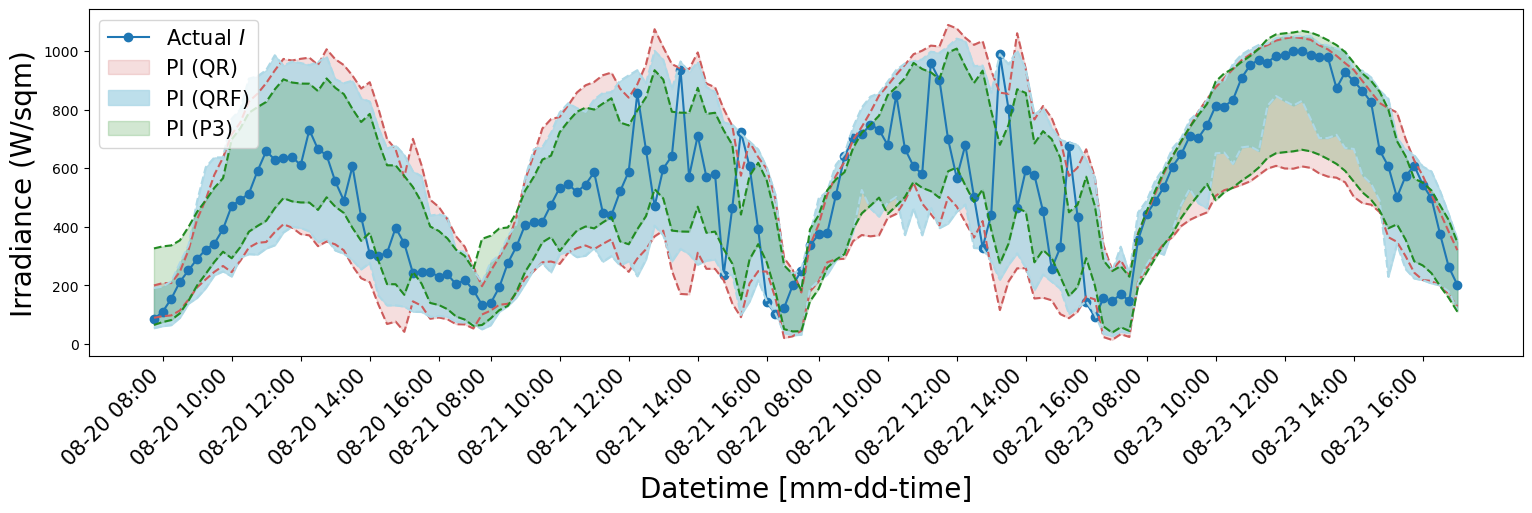

In [23]:
#Plot only QR and P3
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(18.5, 4.5)

#Random the dates to plot
# ndays = 5
# all_date = pd.unique(train.index.date)
# start_date = all_date[np.random.randint(0, high= len(all_date)-ndays+1)]
# end_date = start_date+timedelta(days=ndays)
start_date = '2022-08-20'
end_date = '2022-08-23'
print(start_date)
print(end_date)

color_list = ['indianred','lightblue','forestgreen']
dec_show = 0.5


## Plot QR
y_test_all_QR = pd.concat([All_y_train_QR[0].loc[start_date:end_date], All_y_train_QR[1].loc[start_date:end_date], All_y_train_QR[2].loc[start_date:end_date]]).sort_index()
y_test_plot_QR = y_test_all_QR
y_test_plot_QR.index = y_test_plot_QR.index.map(str)

## Plot QRF
y_test_all_QRF = pd.concat([All_y_train_QRF[0].loc[start_date:end_date], All_y_train_QRF[1].loc[start_date:end_date], All_y_train_QRF[2].loc[start_date:end_date]]).sort_index()
y_test_plot_QRF = y_test_all_QRF
y_test_plot_QRF.index = y_test_plot_QRF.index.map(str)

## Plot P3
y_test_all_P3 = pd.concat([All_y_train_P3[0].loc[start_date:end_date], All_y_train_P3[1].loc[start_date:end_date], All_y_train_P3[2].loc[start_date:end_date]]).sort_index()
y_test_plot_P3 = y_test_all_P3
y_test_plot_P3.index = y_test_plot_P3.index.map(str)

ax.plot(y_test_plot_QR.index,y_test_plot_QR["I"],marker="o",label="Actual $I$")
ax.plot(y_test_plot_QR.index,y_test_plot_QR["Quantile: "+str(quantiles[0])],linestyle="dashed",color=color_list[0])
ax.plot(y_test_plot_QR.index,y_test_plot_QR["Quantile: "+str(quantiles[1])],linestyle="dashed",color=color_list[0])

ax.plot(y_test_plot_QRF.index,y_test_plot_QRF["QRF Quantile: "+str(quantiles[0])],linestyle="dashed",color=color_list[1])
ax.plot(y_test_plot_QRF.index,y_test_plot_QRF["QRF Quantile: "+str(quantiles[1])],linestyle="dashed",color=color_list[1])

ax.plot(y_test_plot_P3.index,y_test_plot_P3["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec_show)],linestyle="dashed",color=color_list[2])
ax.plot(y_test_plot_P3.index,y_test_plot_P3["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec_show)],linestyle="dashed",color=color_list[2])

ax.fill_between(y_test_plot_QR.index, y_test_plot_QR["Quantile: "+str(quantiles[0])],y_test_plot_QR["Quantile: "+str(quantiles[1])],color=color_list[0],alpha=0.2,label="PI (QR)")
ax.fill_between(y_test_plot_QRF.index, y_test_plot_QRF["QRF Quantile: "+str(quantiles[0])],y_test_plot_QRF["QRF Quantile: "+str(quantiles[1])],color=color_list[1],alpha=0.8,label="PI (QRF)")
ax.fill_between(y_test_plot_P3.index, y_test_plot_P3["Quantile: "+str(quantiles[0])+"decrease factor: "+str(dec_show)],y_test_plot_P3["Quantile: "+str(quantiles[1])+"decrease factor: "+str(dec_show)],color=color_list[2],alpha=0.2,label="PI (P3)")

# ax.set_title('Comparing PI from QR, QRF, and P3',fontsize=15)
ax.set_xlabel("Datetime [mm-dd-time]",fontsize=20)
ax.set_ylabel("Irradiance (W/sqm)",fontsize=20)
ax.legend(fontsize=15)


xtick_positions = list(y_test_plot_QR.index)
xtick_labels = list(y_test_plot_QR.index) 
plt.xticks(xtick_positions, xtick_labels, rotation=45, ha="right")

xtick_positions = []
xtick_labels = []

for i, date in enumerate(list(y_test_plot_QR.index)):
     if date[-8:-3:1] in ['08:00','10:00','12:00','14:00','16:00']:
        xtick_positions.append(date)
        date_add = date[5:10:1]+' '+date[-8:-3:1]
        xtick_labels.append(date_add)
# Set x-ticks
plt.xticks(xtick_positions, xtick_labels,rotation = 45, ha="right",fontsize = 15)

# report_savefig('qrqrfp3_solarplot')


## Reliability diagram

In [24]:
# Load test set
with open(os.path.join(resultfolderpath, 'width_dict_test_qr.pkl'), 'rb') as pickle_file:
    width_dict_test_QR = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_test_qr.pkl'), 'rb') as pickle_file:
    PICP_test_QR = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_test_qrf.pkl'), 'rb') as pickle_file:
    width_dict_test_QRF = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_test_qrf.pkl'), 'rb') as pickle_file:
    PICP_test_QRF = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_test_p1.pkl'), 'rb') as pickle_file:
    width_dict_test_P1 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_test_p1.pkl'), 'rb') as pickle_file:
    PICP_test_P1 = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'width_dict_test_p3.pkl'), 'rb') as pickle_file:
    width_dict_test_P3 = pickle.load(pickle_file)
with open(os.path.join(resultfolderpath, 'picp_dict_test_p3.pkl'), 'rb') as pickle_file:
    PICP_test_P3 = pickle.load(pickle_file)

with open(os.path.join(resultfolderpath, 'picp_dict_test_p3_05.pkl'), 'rb') as pickle_file:
    PICP_test_P3_05 = pickle.load(pickle_file)

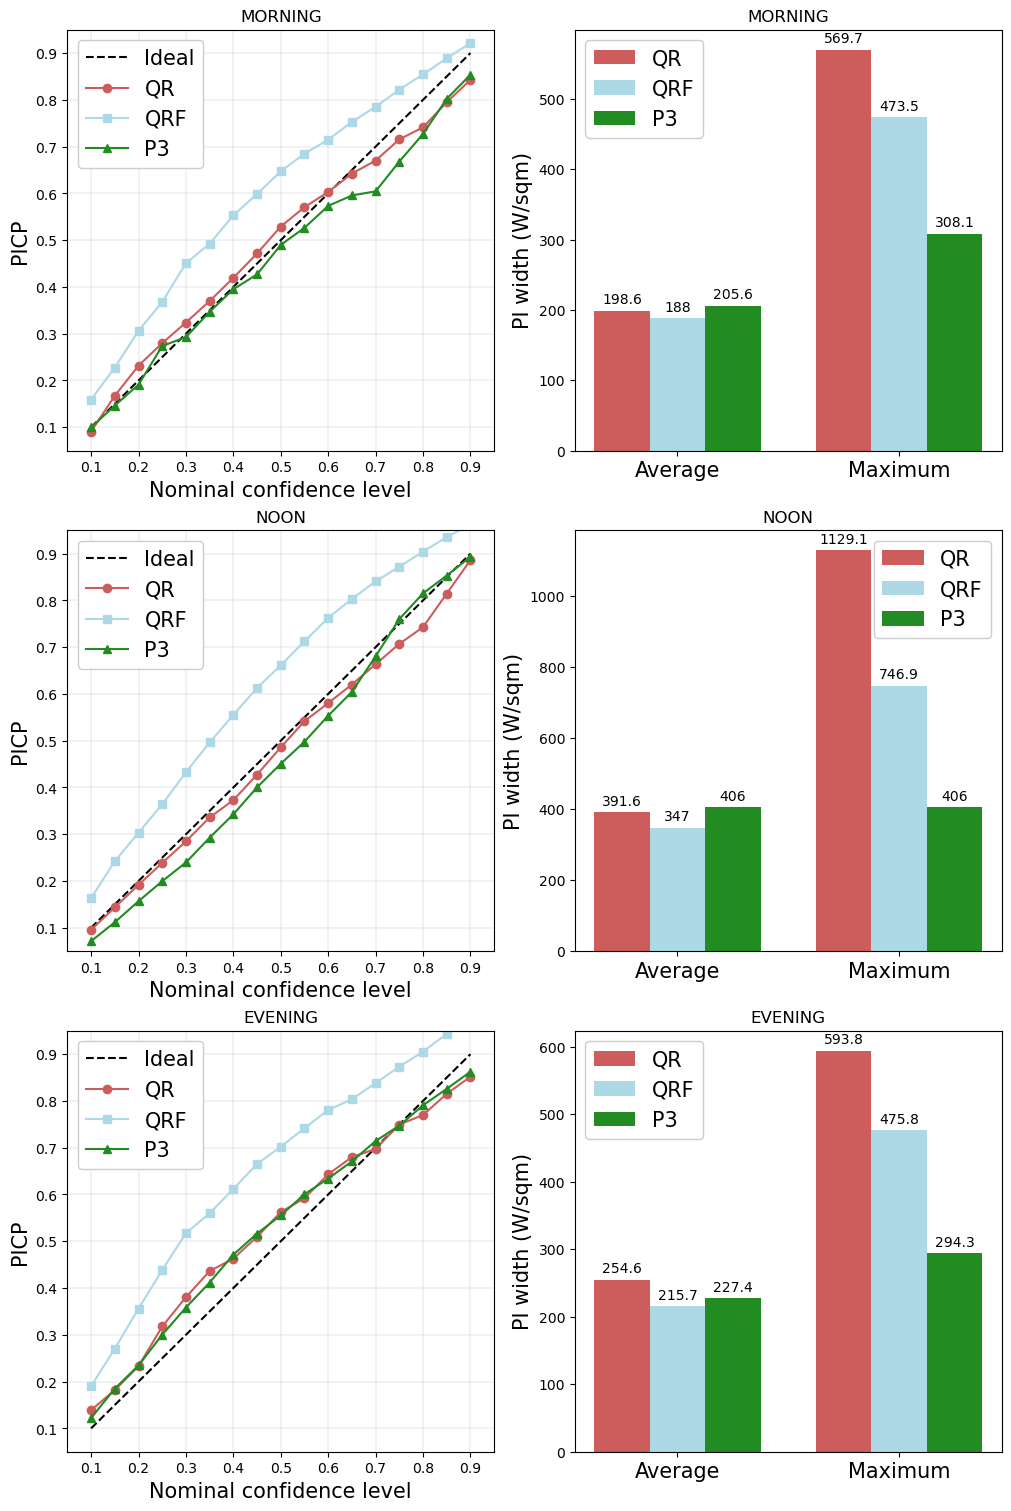

In [25]:
## PICP and width tradeoff
nrows = 3
ncols = 2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,layout='constrained')
fig.set_size_inches(10, 15)
dec_show = 0.5
quantiles = [0.05,0.95]
conf_interval_list = list(np.round(np.arange(0.1, 0.91, 0.05),2))
dec_factor = list(np.round(np.arange(0.02, 1.02, 0.02),2))
color_list = ['indianred','lightblue','forestgreen']


for i in range(3):
    if i == 0:
        period = "morning"
    elif i == 1:
        period = "noon"
    else:
        period = "evening"

    # Reliability diagram
    ax[i,0].set_ylabel("PICP",fontsize = 15)
    ax[i,0].set_xlabel("Nominal confidence level",fontsize = 15)
    ax[i,0].set_title(period.upper())
    
    ax[i,0].plot(conf_interval_list,conf_interval_list,c='k',linestyle='dashed',label='Ideal')
    #QR
    ax[i,0].plot(conf_interval_list,PICP_test_QR[period],c=color_list[0],marker="o",label='QR')
    #QRF
    ax[i,0].plot(conf_interval_list,PICP_test_QRF[period],c=color_list[1],marker="s",label='QRF')
    #P3
    ax[i,0].plot(conf_interval_list,PICP_test_P3_05[period],c=color_list[2],marker="^",label='P3')
    
    ax[i,0].legend(fontsize = 15,framealpha=1)
    ax[i,0].set_xlim(0.05,0.95)
    ax[i,0].set_ylim(0.05,0.95)
    ax[i,0].grid(color='k', linestyle='dashed', linewidth=0.1)
    
    # Width diagram
    qr_avg_width = round(width_dict_test_QR[period,'avg'][conf_interval_list.index(0.9)],1)
    qr_max_width = round(width_dict_test_QR[period,'max'][conf_interval_list.index(0.9)],1)
    qrf_avg_width = round(width_dict_test_QRF[period,'avg'][conf_interval_list.index(0.8)],1)
    qrf_max_width = round(width_dict_test_QRF[period,'max'][conf_interval_list.index(0.8)],1)
    p3_avg_width = round(width_dict_test_P3[period,'avg'][dec_factor.index(dec_show)],1)
    p3_max_width = round(width_dict_test_P3[period,'max'][dec_factor.index(dec_show)],1)
    
    width_type = ("Average", "Maximum")
    bar_colors = ['indianred','lightblue','forestgreen']
    width_measures = {
        'QR': (qr_avg_width, qr_max_width),
        'QRF': (qrf_avg_width, qrf_max_width),
        'P3': (p3_avg_width, p3_max_width),
    }

    x = np.arange(len(width_type))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement, color in zip(width_measures.keys(), width_measures.values(), bar_colors):
        offset = width * multiplier
        rects = ax[i,1].bar(x + offset, measurement, width, label=attribute, color=color)
        ax[i,1].bar_label(rects, padding=3)
        multiplier += 1    

    ax[i,1].set_title(period.upper())
    ax[i,1].set_ylabel("PI width (W/sqm)",fontsize = 15)
    ax[i,1].set_xticks(x + width, width_type,fontsize=15)
    ax[i,1].legend(fontsize = 15,framealpha=1)

# report_savefig('test_reliability_width')

# Uncertainties in converting irradiance to solar power

In [26]:
# Import data
filename = 'ISL_data_20220101_20230630.csv'
site = 'ISL001'

df_measure = pd.read_csv(os.path.join(datasolarfolderpath,filename),index_col='Datetime',parse_dates=['Datetime'])
df_measure = df_measure[df_measure['site_name']==site]
df_measure = df_measure.dropna()
df_measure = df_measure.between_time('07:00','17:00')
df_measure = df_measure[(df_measure != 0).all(axis=1)]
N = 1000 #Number of samples
df_measure = df_measure.sample(n=N)

ac_capacity = 875 # Site data
x = np.array(df_measure['measure_ghi'])/1000 #convert unit to kW/sqm
y = np.array(df_measure['generated_power'])/ac_capacity #convert unit to per unit power
# Import model from solar experiment
model = sm.load(os.path.join(resultfolderpath, 'converting_i_p.pickle'))

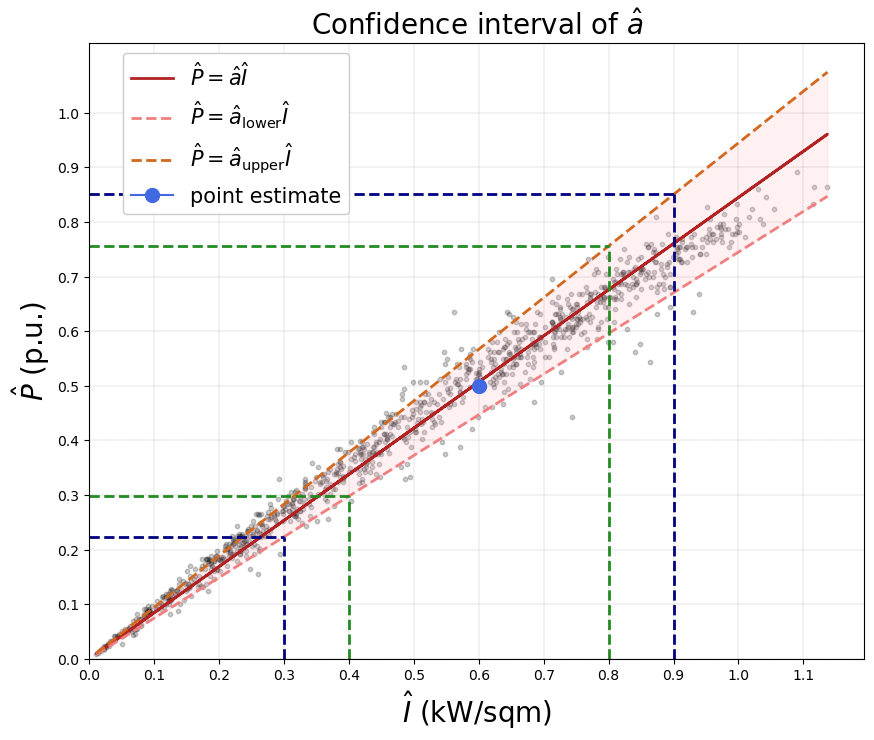

In [27]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 8)
alpha = 0.05 # 95% interval
# Real confidence interval
confidence_interval = model.conf_int(alpha)
# Confidence interval for showing
std = 0.1
confidence_interval = np.array([[model.params[0]-std,model.params[0]+std]])

x_sort = np.sort(x)
y_pred_stat = model.predict(x)
l = confidence_interval[0,0]*x_sort
u = confidence_interval[0,1]*x_sort

color_list = ['indianred']
ax.scatter(x,y,s=10,color='k',alpha=0.2)
ax.plot(x,y_pred_stat,color = 'firebrick', linewidth=2, label = r'$\hat{P} = \hat{a} \hat{I}$')
ax.plot(x_sort,l, color = 'lightcoral',linestyle = 'dashed', linewidth=2, label = r'$\hat{P} = \hat{a}_{\text{lower}} \hat{I}$')
ax.plot(x_sort,u, color = 'chocolate',linestyle = 'dashed', linewidth=2, label = r'$\hat{P} = \hat{a}_{\text{upper}} \hat{I}$')

#Deterministic plot
ax.plot(0.6, 0.5, color = 'royalblue',marker = 'o', markersize = 10, label = 'point estimate')
ax.fill_between(x_sort, l, u, color = 'lightpink', alpha = 0.2)

piwidth = [0.4,0.6]
low = 0.4
high = 0.3
low_pi = [low,low + piwidth[0]]
high_pi = [high, high + piwidth[1]]
color_list = ['forestgreen', 'navy']

for i in range(len(low_pi)):
    ax.plot([low_pi[i], low_pi[i]], [0, low_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[0], linewidth=2)
    ax.plot([0, low_pi[i]], [low_pi[i]*confidence_interval[0,i], low_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[0], linewidth=2)
    ax.plot([high_pi[i], high_pi[i]], [0, high_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[1], linewidth=2)
    ax.plot([0, high_pi[i]], [high_pi[i]*confidence_interval[0,i], high_pi[i]*confidence_interval[0,i]], linestyle='--', color=color_list[1], linewidth=2)

ax.set_xlabel('$\hat{I}$ (kW/sqm)',fontsize = 20)
ax.set_ylabel('$\hat{P}$ (p.u.)', fontsize = 20)
ax.set_title(r'Confidence interval of $\hat{a}$',fontsize = 20)
ax.set_xlim(0)
ax.set_ylim(0)

ax.xaxis.set_ticks(np.arange(0, np.max(x), 0.1))
ax.yaxis.set_ticks(np.arange(0, np.max(u), 0.1))

ax.grid(color='k', linestyle='dashed', linewidth=0.1)
ax.legend(fontsize = 15, framealpha = 1, loc = 'upper left', bbox_to_anchor=(0.03, 1))

# report_savefig('confidence_converting_irr_power')